# Projet n°7 : Implémentez un modèle de scoring

## Enoncé général du projet 

Vous êtes Data Scientist au sein d'une société financière, nommée "**Prêt à dépenser**", qui propose des **crédits à la consommation** pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “__scoring crédit__” pour calculer la <span style="color:blue">probabilité qu’un client rembourse son crédit</span>, puis **classifie la demande en crédit accordé ou refusé** (binaire, bool, true/false). 

Elle souhaite donc développer un **algorithme de classification en s’appuyant sur des sources de <span style="color:blue">données variées</span>** (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de **transparence** vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un **dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

# Librairies

In [1]:
# import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import time
import re
from random import * # sélection de chiffres au hasard
import gc
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, dummy, tree, ensemble
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from lime import lime_tabular
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from random import * # sélection de chiffres au hasard
import mlflow
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from mlflow.models.signature import infer_signature
import joblib
import pickle
import dill

/Users/sandrineveloso/opt/anaconda3/envs/OCR_env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data input 
<span style="color:blue">**WARNING :** Data input and output should be adapted to each user.      
Two modes for this script : Run and Optimisation.  
In Optimisation mode, models are optimized and stored locally.    
If you want only to run these models, you have to download and indicated the path of the datafile '**models_storages**'
</span>

In [2]:
path = '../../DATA/INPUT/Projet+Mise+en+prod+-+home-credit-default-risk/'
output_path = 'output/'
path_models_store = 'models_storage/'
api_path = 'api/data/'

---

Active run_id: 3c4e23f991c746c7a3075b83315fc9f7
Mode : OPT
Process bureau and bureau_balance - done in 18s
Process previous_applications - done in 19s
Process POS-CASH balance - done in 11s
Process installments payments - done in 26s
Process credit card balance - done in 13s

Pourcent of features with missing data (NaN):  77.4  %
Equivalent to 212 features in less
Resampled dataset shape Counter({0.0: 113072, 1.0: 56536})


/var/folders/64/zs70zl353j533472z7r7csxc0000gn/T/ipykernel_2334/1861947130.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['TARGET'] = target.copy()


Data final preparation - done in 77s
------------------------------------------------------------
Optimization of Gradient Boosting Classifier


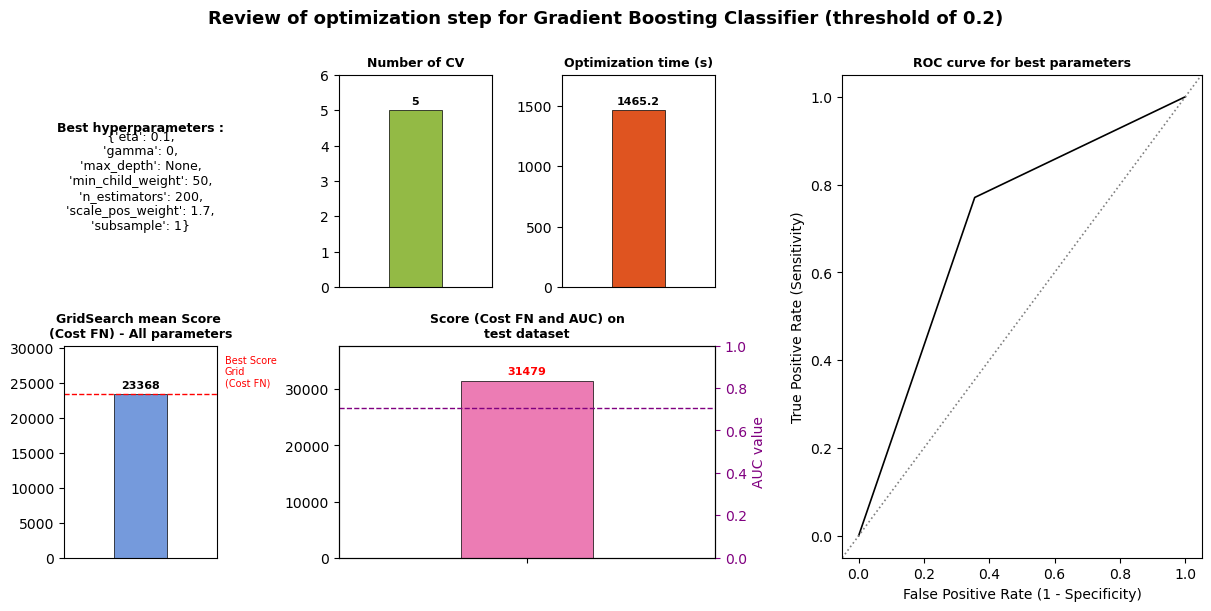

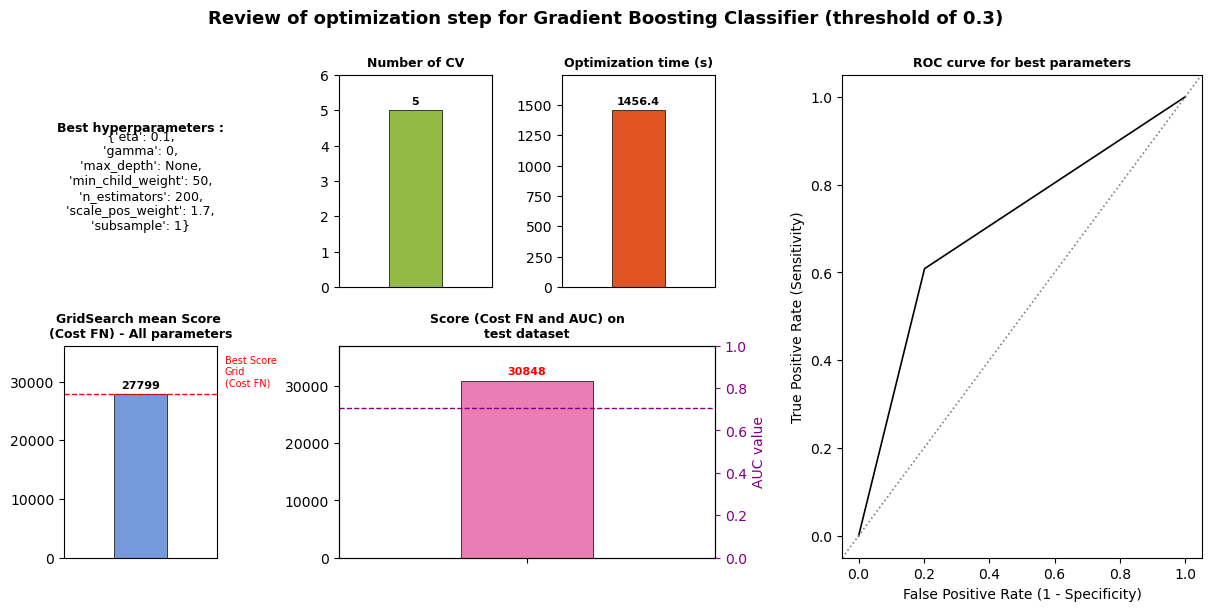

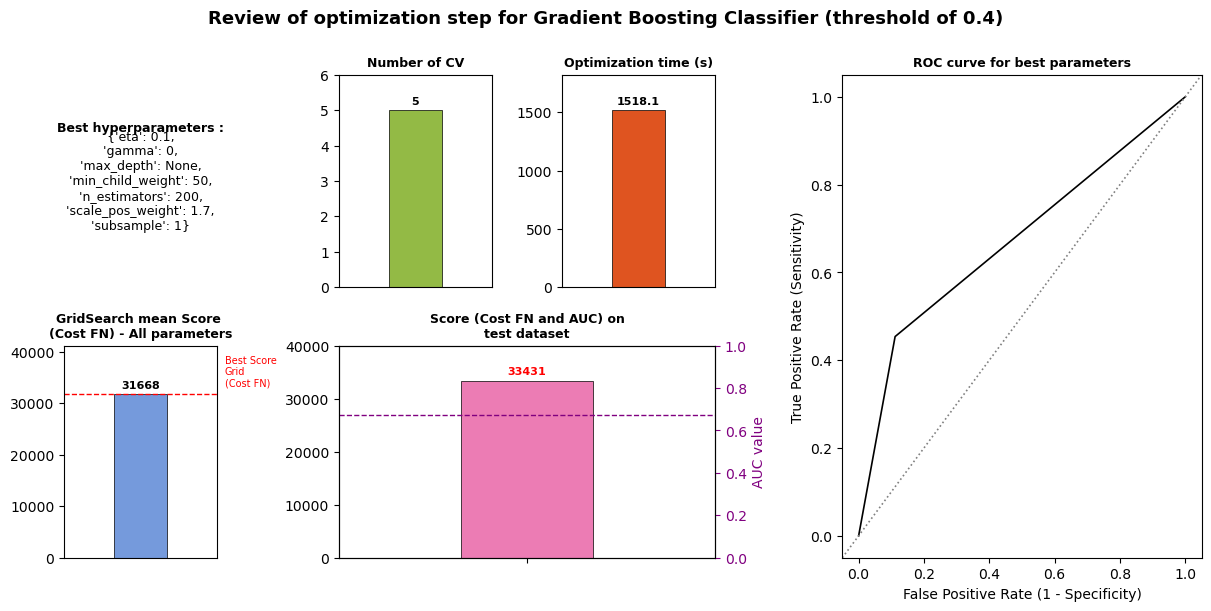

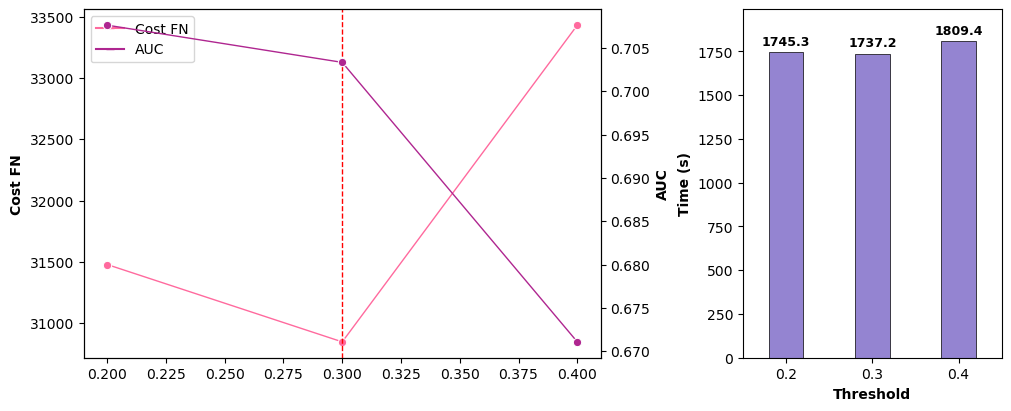

/Users/sandrineveloso/opt/anaconda3/envs/OCR_env/lib/python3.8/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
2023/03/07 16:02:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/64/zs70zl353j533472z7r7csxc0000gn/T/tmptx

Full model run - done in 5468s


In [4]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# From the kernel creator (https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script)
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------
# GENERIC FUNCTIONS 
# ------------------------------------------------------------------------------------------------------------------------------------------------
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Local dataframe used to store infos
def temporary_df():
    # Function to create empty but formatted dataframe
    info = pd.DataFrame(columns = ['model','fit time','prediction time','precision','recall','accuracy','f1 score','AUC',\
                                   "Cost","Loss",'Shortfall'])
    roc = pd.DataFrame(columns = ['model','fpr','tpr','AUC'])
    conf = pd.DataFrame(columns = ['model','TN','FN','TP','FP'])
    return info, roc, conf

# Fast calcul of the pourcent of features composed of missing data
def PourcentNa(dataframe):
    Pourcent=dataframe.isna().sum()/len(dataframe)*100
    PourcentNadf = Pourcent.loc[Pourcent != 0]
    print("\nPourcent of features with missing data (NaN):", startbold,round(len(PourcentNadf)/len(dataframe.columns)*100,1),endbold,"%")

def dataframe_NaN_cleaning_step(dataframe, limit_percent_NaN):
    '''Dropping all columns with more than a threshold pourcent of missing data'''
    original_dimension = dataframe.shape
    min_count =  int(((100-limit_percent_NaN)/100) * dataframe.shape[0] + 1)
    dataframe.dropna(axis=1, thresh=min_count, inplace=True)
    print("Equivalent to",original_dimension[1]-dataframe.shape[1],"features in less")
    return dataframe.columns

# ------------------------------------------------------------------------------------------------------------------------------------------------
# DATA PREPARATION 
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Preprocess application_train.csv and application_test.csv
def application_train_test(nan_as_category = False): 
    # Read data and merge
    df = pd.read_csv(path + 'application_train.csv')
    test_df = pd.read_csv(path + 'application_test.csv')
    df = df.append(test_df).reset_index() # Distinction between test and train via "TARGET" variable
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    first_cat_list = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    for bin_feature in first_cat_list:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
    
    # Categorical features with One-Hot encode
    df, categorial_columns  = one_hot_encoder(df, nan_as_category) # storage of categorial_columns for a better tracking
    joined_cat_list = [*categorial_columns, *first_cat_list]

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df, joined_cat_list

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(nan_as_category = True): 
    bureau = pd.read_csv(path + 'bureau.csv')
    bb = pd.read_csv(path + 'bureau_balance.csv')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    cat_list = bb_cat.append(bureau_cat)
    return bureau_agg, cat_list

# Preprocess previous_applications.csv
def previous_applications(nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']}
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg, cat_cols

# Preprocess POS_CASH_balance.csv
def pos_cash(nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg, cat_cols
    
# Preprocess installments_payments.csv
def installments_payments(nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category)

    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg, cat_cols

# Preprocess credit_card_balance.csv
def credit_card_balance(nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)

    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg, cat_cols

# Final data preparation - for models comparaison
# Train and test split, remove of feature with more tha 60% of missing data, missing data implementation, correction of unbalanced classes
def final_data_preparation(df):
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # remove all ID feature useless for modelisation step
    # ----------------------------------------------------------------------------------
    # Dropping all columns with more than 60% missing data : 
    del_col = dataframe_NaN_cleaning_step(df[feats], 60.0)
    feats = [f for f in feats if f in del_col] # Remove columns with more than 60% of missing data from feats
    # ----------------------------------------------------------------------------------
    # there is somme infinite value in the dataset, we will replace these values by missing value (NaN)
    for col in ["INSTAL_PAYMENT_PERC_MAX","PREV_APP_CREDIT_PERC_MAX"]:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan) 

    # remplace missing data (NaN) 
    for col in feats:
        if df[col].isna().values.sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)
    # ----------------------------------------------------------------------------------
    # Split datasets between modelisation and post-production :
    # Note : this application test is not for the model test phase by for the model prediction phase
    application_train_df = df[df['TARGET'].notnull()]
    application_test_df = df[df['TARGET'].isnull()] 

    # Saving parameters in MLFLOW tracking
    mlflow.log_param("Modelisation dataset", application_train_df.shape)
    mlflow.log_param("Prediction dataset", application_test_df.shape)
    # ----------------------------------------------------------------------------------
    # Split datasets in two for training and testing stages
    train, test = train_test_split(application_train_df, test_size=0.2, random_state=random_state, stratify=application_train_df["TARGET"]) 
    mlflow.log_param("Modelisation training set", train.shape)
    mlflow.log_param("Modelisation test set", test.shape)

    test = test[feats + ["TARGET"]] # For the test phase, we will not need the other features

    # For modelisation train dataset : class re-sampling to corrected unbalanced category
    over = SMOTE(random_state=random_state, sampling_strategy=0.25)
    under = RandomUnderSampler(sampling_strategy=.5, random_state=random_state)
    steps = [('o', over), ('u', under)] # First step of oversampling and Second step of undersampling
    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    train, target = pipeline.fit_resample(train[feats], train["TARGET"])
    print('Resampled dataset shape %s' % Counter(target))

    # Rejoined train and target:
    train['TARGET'] = target.copy()
    mlflow.log_param("Modelisation training - set post resampling for unbalanced cat", train.shape)
    del target, pipeline
    gc.collect()
    return application_train_df, application_test_df, train, test, feats

def dataframe_prep_streamlit(df, application_test, flat_cat_list):
    '''DATAFRAME PREPARATION FOR STREAMLIT VISUALIZATION'''
    df_test = df[df['SK_ID_CURR'].isin(application_test['SK_ID_CURR'].tolist())]
    df_test.columns = df_test.columns.str.replace("_"," ")

    # Categorical variable : identification, cleaning and reencoding :
    # with open(output_path + 'cat_feat_list.pkl', 'rb') as f:
    #    categorical_columns = pickle.load(f)

    categorical_features = pd.Series(flat_cat_list).str.rsplit('_', 1).str.get(0).str.replace("_"," ").unique()
    categorical_features = [col for col in categorical_features if col not in ["NAME TYPE SUITE Other", "NAME YIELD GROUP low","CODE","FLAG OWN"]]

    # Remove category only linked to aggregations so not re-encodable
    rem = ["NAME PAYMENT TYPE","FLAG LAST APPL PER CONTRACT","NAME CASH LOAN PURPOSE","NAME CONTRACT STATUS","CODE REJECT REASON",\
           "NAME CLIENT TYPE","NAME GOODS CATEGORY","NAME PORTFOLIO","NAME PRODUCT TYPE","CHANNEL TYPE","NAME SELLER INDUSTRY",\
            "NAME YIELD GROUP","PRODUCT COMBINATION"]
    categorical_features = [col for col in categorical_features if col not in rem]

    # Reencoding of categorial variables :
    df_test['CODE GENDER'] = df_test['CODE GENDER'].apply(lambda x : "M" if x==0 else "F")
    df_test['FLAG OWN CAR'] = df_test['FLAG OWN CAR'].apply(lambda x : "No" if x==0 else "Yes")
    df_test['FLAG OWN REALTY'] = df_test['FLAG OWN REALTY'].apply(lambda x : "Yes" if x==0 else "No")

    for i in range(len(categorical_features)):
        list = df_test.columns[df_test.columns.str.contains(categorical_features[i]) & ~df_test.columns.str.contains("PREV ") & ~df_test.columns.str.contains("POS ") \
                            & ~df_test.columns.str.contains("CC ") & ~df_test.columns.str.contains("XNA")]
        cat = df_test[list].idxmax(1).str.replace(categorical_features[i]+" ","")
        df_test[categorical_features[i]] = cat
        df_test.drop(list.tolist(),axis=1,inplace=True)

    full_cat_list = categorical_features + ['CODE GENDER', 'FLAG OWN CAR', 'FLAG OWN REALTY']

    # Some correction of strings : 
    df_test["NAME CONTRACT TYPE"] = df_test["NAME CONTRACT TYPE"].str.replace("Revolvingloans","Revolving loans")
    df_test["NAME TYPE SUITE"] = df_test["NAME TYPE SUITE"].str.replace("Groupofpeople","Group of people").str.replace("Spousepartner","Spouse/partner").str.replace("Other B","Other").str.replace("Other A","Other")
    df_test["NAME HOUSING TYPE"] = df_test["NAME HOUSING TYPE"].str.replace("apartment"," apartment").str.replace("Withparents"," With parents")
    df_test["OCCUPATION TYPE"] = df_test["OCCUPATION TYPE"].str.replace("staff"," staff").str.replace("Realtyagents","Realty agents").str.replace("LowskillLaborers","Low skill Laborers").\
        str.replace("Highskilltech","High skill tech").str.replace("Privateservice","Private service").str.replace("Waitersbarmen","Waiters/barmen")
    df_test['WEEKDAY APPR PROCESS START'] = df_test['WEEKDAY APPR PROCESS START'].str.capitalize()
    df_test["NAME INCOME TYPE"] = df_test["NAME INCOME TYPE"].str.replace("Stateservant","State servant").str.replace("Commercialassociate","Commercial associate")
    df_test["NAME FAMILY STATUS"] = df_test["NAME FAMILY STATUS"].str.replace("Singlenotmarried","Single/not married").str.replace("Civilmarriage","Civil marriage")
    df_test["NAME EDUCATION TYPE"] = df_test["NAME EDUCATION TYPE"].str.replace("Highereducation","Higher education").str.replace("Secondarysecondaryspecial","Secondary/secondary special")\
        .str.replace("Incompletehigher","Incomplete higher").str.replace("Lowersecondary","Lower secondary").str.replace("Academicdegree","Academic degree")
    df_test["FONDKAPREMONT MODE"] = df_test["FONDKAPREMONT MODE"].str.replace("notspecified","Not specified").str.replace("account"," account").str.capitalize()
    df_test["HOUSETYPE MODE"] = df_test["HOUSETYPE MODE"].str.replace("blockofflats","Block of flats").str.replace("specifichousing","Specific housing").str.replace("terracedhouse","Terraced house")
    df_test["ORGANIZATION TYPE"].loc[df_test["ORGANIZATION TYPE"].str.contains("Transporttype")] = "Transport type"
    df_test["ORGANIZATION TYPE"].loc[df_test["ORGANIZATION TYPE"].str.contains("Industrytype")] = "Industry type"
    df_test["ORGANIZATION TYPE"].loc[df_test["ORGANIZATION TYPE"].str.contains("Tradetype")] = "Trade type"
    df_test["ORGANIZATION TYPE"].loc[df_test["ORGANIZATION TYPE"].str.contains("BusinessEntityType")] = "Business Entity Type"
    df_test["ORGANIZATION TYPE"] = df_test["ORGANIZATION TYPE"].str.replace("Selfemployed","Self employed").str.replace("LegalServices","Legal Services").str.replace("SecurityMinistries","Security Ministries")
    del df
    df_test.to_csv(api_path + "df_test_st_support.csv", index= False) 

# ------------------------------------------------------------------------------------------------------------------------------------------------
# SCORING
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Scoring functions - We adapted the metric in order to reduce the amount of false negative
def cost_fn(y_true, y_prob, thres):
    fp = np.where((y_prob >= thres) & (y_true==0),1,0)
    fn = np.where((y_prob <= thres) & (y_true==1), 10, 0)
    return np.sum([fn,fp])

# Display/plot of cost FN (local scoring method)
def cost_FN_selection_display(thre_auc_):
    thre_auc_=thre_auc_.drop(["best_params"],axis=1)
    fig = plt.figure(constrained_layout=True,figsize=(10,4))
    axd = fig.subplot_mosaic(
        """
        AAB
        """)
    g = sns.lineplot(data=thre_auc_, x=thre_auc_.columns.tolist()[0], y=thre_auc_.columns.tolist()[1],color="#ff6a9e",markers=True, lw=1,marker="o",ax=axd['A'])
    # axd["A"].set_ylabel(color='black',fontsize=10,fontweight="bold")
    ax2 = g.axes.twinx()
    sns.lineplot(data=thre_auc_, x=thre_auc_.columns.tolist()[0], y=thre_auc_.columns.tolist()[2], ax=ax2,color="#af2690",markers=True, lw=1,marker="o")
    g.legend(handles=[Line2D([], [], marker='_', color="#ff6a9e", label=thre_auc_.columns.tolist()[1]), Line2D([], [], marker='_', \
                                                                                                               color="#af2690", label=thre_auc_.columns.tolist()[2])])
    axd["A"].set_xlabel("")
    axd["A"].axvline(thre_auc_["threshold"].iloc[np.argmin(thre_auc_["Cost FN"])], color = "red",linestyle="--",lw=1)
    axd["A"].set_ylabel("Cost FN",color='black',fontsize=10,fontweight="bold")
    ax2.set_ylabel("AUC",color='black',fontsize=10,fontweight="bold")

    ax = sns.barplot(data=thre_auc_, x=thre_auc_.columns.tolist()[0], y=thre_auc_.columns.tolist()[3], color="#8c77de",width=0.4, \
                     ax=axd['B'],edgecolor="black",linewidth=.5)
    for i in ax.containers:
        ax.bar_label(i,fmt='%.1f', padding=3,fontsize=9,fontweight="bold")
    ax.set(ylim=(0, max(thre_auc_[thre_auc_.columns.tolist()[3]])+max(thre_auc_[thre_auc_.columns.tolist()[3]])*10/100))
    axd["B"].set_xlabel("Threshold",color='black',fontsize=10,fontweight="bold")
    axd["B"].set_ylabel("Time (s)",color='black',fontsize=10,fontweight="bold")
    plt.show()

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    best_features["feature"] = best_features["feature"].str.replace("_"," ")
    plt.figure(figsize=(6, 10))
    g = sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False), edgecolor="black",\
                    linewidth=.5,palette=sns.color_palette("Spectral", 40), saturation=1, alpha = .9, width=0.6)
    g.set_xlabel('Importance', fontdict={'size': 10, 'weight': 'bold', 'color': 'black'})
    g.set_ylabel('')
    g.set_title('Best model : Global features importances',fontdict={'size': 11.5, 'weight': 'bold', 'color': 'black'})
    for tick in g.yaxis.get_major_ticks():
                    tick.label.set_fontsize(9)
    for tick in g.xaxis.get_major_ticks():
                    tick.label.set_fontsize(9)
    plt.savefig(output_path + mode + '/global_feat_importance.png')
    mlflow.log_artifact(output_path + mode + '/global_feat_importance.png')
    
# Calcul of all 'classic' score (accuracy, precision, etc.)
def score_calcul(y_true,y_pred,mean_loan):
    prec = precision_score(y_true, y_pred) # precision = TP / (FP + TP)
    recall = recall_score(y_true, y_pred)  # recall = TP / (FN + TP)
    accuracy = accuracy_score(y_true, y_pred) # accuracy = (TP + TN)/ (TP + FN + TN + FP)
    f1 = f1_score(y_true, y_pred) # F1 Score =  harmonic mean of precision and recall score
    fpr, tpr, _ = roc_curve(y_true,  y_pred) # False Positif and False Negatif rates
    auc = roc_auc_score(y_true, y_pred) # AUC
    conf = confusion_matrix(y_true, y_pred) # Confusion matrix 

    # False Positif and False Positif
    FN = conf[1,0]
    FP = conf[0,1]
    # Local scoring : Count of False (with FN markup)
    cout_met = 10*FN + FP
    # Loss and Shortfall (both calculated from mean loan)
    loss = FN * mean_loan
    shortfall = FP * mean_loan * 2/100 # hypothetical loan rate (2%)
    return prec, recall, accuracy, f1, auc, fpr, tpr, cout_met, loss, shortfall

# Display/plot 'classic' score (accuracy, precision, etc.)
def display_models_info(model_info): 
    fig = plt.figure(constrained_layout=True,figsize=(14, 7))
    axd = fig.subplot_mosaic(
                        """
                        ABDD
                        EEFF
                        """)
    fig.suptitle("Model Scoring Display\n", fontsize=15,fontweight="bold")
    model_info["Loss"] =  model_info["Loss"] + model_info["Shortfall"] # The two plot will be display one on top of the other
    model_info_melt = model_info.melt('model', var_name='parameters', value_name='value')
    model_info_melt["model"] = model_info_melt["model"].replace(' ', '\n', regex=True)
    feat = model_info_melt["parameters"].unique()
    plot_number = ['A','B','C','C','C','C','C','D','E','F']

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params) # 

    for i in range(8):
        support = model_info_melt[model_info_melt["parameters"]==feat[i]].drop(["parameters"], axis=1)
        marker_list = ["^","o","s","h","p"]

        if 2 <= i < 7:
            j = i - 2
            axd['E'].plot(support['model'],support['value'], '--', color="grey", linewidth=.5)
            axd['E'].scatter(support['model'],support['value'], color=sns.color_palette("Spectral", len(model_info["model"])), s=70, alpha=0.85, \
                edgecolor ="black", marker=marker_list[j], linewidths = .7, label=feat[i].capitalize())
            for tick in axd['E'].xaxis.get_major_ticks():
                tick.label.set_fontsize(10)
            for tick in axd['E'].yaxis.get_major_ticks():
                tick.label.set_fontsize(10)
            axd['E'].legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), shadow=False, ncol=5);
            axd['E'].set_title('Performance metric',fontdict={'size': 12, 'weight': 'bold', 'color': '#5c677d'})
            axd['E'].set_ylabel('Value',fontweight="bold")
            
        else:
            g = sns.barplot(data=support, x="model", y="value", width=0.45, ax=axd[plot_number[i]],edgecolor="black",linewidth=.5,\
                    palette=sns.color_palette("Spectral", len(model_info["model"])), saturation=1)
            g.set_xlabel('')
            plot_title = feat[i].capitalize()
            g.set_title(plot_title,fontdict={'size': 12, 'weight': 'bold', 'color': '#5c677d'})
            for tick in axd[plot_number[i]].yaxis.get_major_ticks():
                tick.label.set_fontsize(10)

        if i<2:
            g.set_ylabel('Time (s)',fontweight="bold")
            for tick in axd[plot_number[i]].xaxis.get_major_ticks():
                tick.label.set_fontsize(9)
        else:
            g.set_ylabel('Value',fontweight="bold")

        # Legend correction 
    for ha in axd['E'].legend_.legendHandles:
            ha.set_color("white")
            ha.set_edgecolor("black")

        # Display Loss and Shortfall
    support = model_info_melt[model_info_melt["parameters"]==feat[8]].drop(["parameters"], axis=1)
    sns.barplot(x = 'model', y = 'value', data = support, width=0.6, edgecolor = 'black', ax=axd['F'], linewidth=.5,\
            palette=sns.color_palette("Spectral", len(model_info["model"])), saturation=1, label = feat[8]) # label = 'Total', color = 'b', edgecolor = 'w')
    support = model_info_melt[model_info_melt["parameters"]==feat[9]].drop(["parameters"], axis=1)
    sns.barplot(x = 'model', y = 'value', data = support, width=0.6, edgecolor = 'black', ax=axd['F'], linewidth=.5,\
            palette=sns.color_palette("Spectral", len(model_info["model"])), saturation=1, label = feat[9]) # ,label = 'Alcohol-involved', color = 'b', edgecolor = 'w')
    hatches = [ "", "////"]
        # Loop over the bars
    for bars, hatch in zip(axd['F'].containers, hatches):
            # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)
    # sns.despine(left = True, bottom = True)
    axd['F'].legend(ncol = 1, loc = 'upper right',fancybox=True,facecolor = 'w')
    axd['F'].set_title("\n\nEstimation of the financial loss and shortfall \n(linked false positive and negative)",fontdict={'size': 12, 'weight': 'bold', 'color': '#5c677d'})
    axd['F'].legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), shadow=False, ncol=2)
    for tick in axd['F'].xaxis.get_major_ticks():
                tick.label.set_fontsize(10)
    for tick in axd['F'].yaxis.get_major_ticks():
                tick.label.set_fontsize(10)
    axd['F'].set_ylabel('\n\nCost (dollars)',fontweight="bold")
    axd['F'].set_xlabel('');

        # Legend correction 
    for ha in axd['F'].legend_.legendHandles:
            ha.set_color("white")
            ha.set_edgecolor("black")

    plt.savefig(output_path + mode + '/Model_Scoring_Display.png')
    mlflow.log_artifact(output_path + mode + '/Model_Scoring_Display.png')

# Display/plot confusion matrix (for all models)
def confusion_matrix_display(conf_matrix):
    fig = plt.figure(constrained_layout=True,figsize=(15, 3.75))
    axd = fig.subplot_mosaic(
                        """
                        ABCDE
                        """)
    fig.suptitle("Confusion matrices for all models\n", fontsize=15,fontweight="bold")

    list_model = conf_matrix["model"].unique().tolist()
    position = ["A","B","C","D","E"]

    for i in range(len(list_model)):
        support = conf_matrix[conf_matrix["model"]==list_model[i]]
        axd[position[i]].set_title(list_model[i]+"\n",fontsize=10.5,fontweight = 'bold')
        axd[position[i]].matshow(np.array([[support["TN"][i],support['FP'][i]],[support["FN"][i],support["TP"][i]]]), cmap=plt.cm.YlGnBu, alpha=0.5)
        axd[position[i]].text(x=0, y=0, s = support["TN"][i], va='center', ha='center', fontsize=11.5)
        axd[position[i]].text(x=1, y=1, s = support["TP"][i], va='center', ha='center', fontsize=11.5)
        axd[position[i]].text(x=0, y=1, s = support["FP"][i], va='center', ha='center', fontsize=11.5)
        axd[position[i]].text(x=1, y=0, s = support["FN"][i], va='center', ha='center', fontsize=11.5)
        axd[position[i]].set_ylabel('\nPredictions', fontsize=10,fontweight = 'bold')
        axd[position[i]].set_xlabel('Actuals', fontsize=10,fontweight = 'bold')
        axd[position[i]].xaxis.tick_bottom()
    plt.savefig(output_path + mode + '/Models_confusion_matrices.png')
    mlflow.log_artifact(output_path + mode + '/Models_confusion_matrices.png')
    
# Display/plot of ROC curves for all models
def display_roc(roc_curves):
    plt.subplots(figsize=(7,5))
    dummy = roc_curves.loc[roc_curves["model"]=="Dummy Classifier"]
    plt.plot(dummy["fpr"][0],dummy["tpr"][0], color=sns.color_palette("Set2", 8)[0], lw=1, label='AUC (dummy): %.2f' % dummy["AUC"][0])
    models = roc_curves.loc[roc_curves["model"]!="Dummy Classifier"]
    models = models.reset_index(drop=True)
    list_model = models['model'].unique()
    for i in range(len(list_model)):
        plt.plot(models["fpr"][i],models["tpr"][i], color=sns.color_palette("Set2", 8)[i+1], lw=1, label='AUC (' + list_model[i] + '): %.2f' % models["AUC"][i])
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("ROC curve (on validation set)",fontsize=12,fontweight="bold")
    plt.legend(loc=4)
    plt.savefig(output_path + mode + '/roc_curves.png')
    mlflow.log_artifact(output_path + mode + '/roc_curves.png')

# ------------------------------------------------------------------------------------------------------------------------------------------------
# MODELS OPTIMIZATION - MODE=="OPT"
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Function allowing models optimization - the mode in the main function have to be switch to "OPT" and a model name should be given
def model_optimization(model_name,train,test,feats,threshold):
    print("Optimization of",model_name)

    if model_name == "Decision tree":
        model = tree.DecisionTreeClassifier(random_state=random_state)
        params = {'max_depth':[30, 50, 100],
                  'criterion':['gini'],
                  'class_weight':['balanced'],
                  'max_features':[None],
                  'min_samples_leaf':[500, 800]
                  }
        
    elif model_name == "Random Forest Classifier":
        model = ensemble.RandomForestClassifier(random_state=random_state)        
        params = {'n_estimators':[100],
                  'criterion':['gini'],
                  'bootstrap':[False],
                  'class_weight': ['balanced'],
                  'max_features': [None]
                }

    elif model_name == "Extra Trees Classifier":
        model = ensemble.ExtraTreesClassifier(random_state=random_state)  
        params = {'n_estimators':[75],
                  'max_depth':[None], 
                  'max_leaf_nodes':[None],
                  'max_features':[None], 
                  'class_weight':['balanced'],
                  'criterion':['entropy'],
                  'bootstrap':[True],
                  'min_samples_split':[500]
                  }

    elif model_name == "Gradient Boosting Classifier":
        model = XGBClassifier(random_state=random_state,use_label_encoder=False, eval_metric='mlogloss')        
        params = {'n_estimators':[200],
                  'max_depth':[None],
                  'scale_pos_weight':[1.7], 
                  'eta':[.1],
                  'gamma': [0], 
                  'min_child_weight':[50],
                  'subsample':[1]
                  }

    mlflow.log_param("OPT GridParam for "+model_name,params) # error
    thre_auc = pd.DataFrame(columns = ['threshold','best_params','Cost FN','AUC','time'])

    for t in threshold:
        t0 = time.time()
        scorer_fn = make_scorer(cost_fn, greater_is_better = False, needs_proba=True, thres = t)
        search = GridSearchCV(model, params, scoring=scorer_fn, cv=cv_val) 
        result = search.fit(train[feats], train['TARGET'])
        OPT_tps_fit = time.time() - t0
        
        # Observation of hyperparameters for better score
        plot_support = pd.DataFrame.from_dict(result.cv_results_['params'])
        plot_support['-score']=-result.cv_results_["mean_test_score"]
        
        if model_name == "Decision tree":
            model = tree.DecisionTreeClassifier(**result.best_params_,random_state=random_state)
        elif model_name == "Random Forest Classifier":
            model =  ensemble.RandomForestClassifier(**result.best_params_,random_state=random_state)
        elif model_name == "Extra Trees Classifier":
            model = ensemble.ExtraTreesClassifier(**result.best_params_, random_state=random_state)
        elif model_name == "Gradient Boosting Classifier":
            model = XGBClassifier(**result.best_params_, random_state=random_state,use_label_encoder=False, eval_metric='mlogloss')
        
        model.fit(train[feats], train['TARGET'])
        yprob = model.predict_proba(test.drop(["TARGET"],axis=1))
        ypred = [1 if x >= t else 0 for x in yprob[:,1]]

        fpr, tpr, _ = roc_curve(test["TARGET"],  ypred)
        best_params = result.best_params_
        OPT_Bilan = pd.DataFrame(columns = ['mean_score_grid',"std_score_grid","best_score_grid","fit_time","CostFN_score_test","num_cv","roc_score_test"])
        OPT_Bilan = OPT_Bilan.append({'mean_score_grid':np.nanmean(-result.cv_results_["mean_test_score"]),
                                    "std_score_grid":np.nanstd(-result.cv_results_["mean_test_score"]),
                                    "best_score_grid":-result.best_score_,
                                    "fit_time":OPT_tps_fit,
                                    'CostFN_score_test':cost_fn(test["TARGET"],yprob[:,1],t),
                                    "num_cv":cv_val,
                                    "roc_score_test":roc_auc_score(test["TARGET"], ypred)}, ignore_index=True)
        display_review_optimization(model_name,OPT_Bilan,best_params,fpr, tpr,t)

        thre_auc = thre_auc.append({'threshold':t,'best_params':result.best_params_,'Cost FN':cost_fn(test["TARGET"],yprob[:,1],t),\
            'AUC':OPT_Bilan["roc_score_test"][0],'time':time.time() - t0}, ignore_index=True)
        
    # Best threshold for models saving : 
    model_thre = thre_auc["threshold"][np.argmin(thre_auc["Cost FN"].rank() + thre_auc["AUC"].rank(ascending=False)*2)] # *2 to give a higher importance value of Cost FN
    with open(path_models_store+model_name+'_threshold.pkl', 'wb') as f:
        pickle.dump(model_thre, f)
    final_best_params = thre_auc['best_params'].loc[thre_auc["threshold"]==model_thre].iloc[0]
    
    mlflow.log_param("OPT Best threshold for "+model_name,model_thre)
    mlflow.log_param("OPT Best param for "+model_name,final_best_params)
    mlflow.log_metric("OPT AUC with best param for "+model_name,thre_auc["AUC"].loc[thre_auc["threshold"]==model_thre].iloc[0])
    mlflow.log_metric("OPT Cost FN with best param for "+model_name,thre_auc["Cost FN"].loc[thre_auc["threshold"]==model_thre].iloc[0])

    cost_FN_selection_display(thre_auc)

    if model_name == "Decision tree":
       model = tree.DecisionTreeClassifier(**final_best_params,random_state=random_state)
       joblib.dump(model, path_models_store+'DecisionTree.joblib')
    
    elif model_name == "Random Forest Classifier":
        model = ensemble.RandomForestClassifier(**final_best_params,random_state=random_state)
        joblib.dump(model, path_models_store+'RandomForestClassifier.joblib')
    
    elif model_name == "Extra Trees Classifier":
        model = ensemble.ExtraTreesClassifier(**final_best_params,random_state=random_state)
        joblib.dump(model, path_models_store+'ExtraTreesClassifier.joblib')

    elif model_name == "Gradient Boosting Classifier":
        model = XGBClassifier(**final_best_params, random_state=random_state,use_label_encoder=False, eval_metric='mlogloss')
        joblib.dump(model, path_models_store+'GradientBoostingClassifier.joblib')

    signature = infer_signature(train[feats], train['TARGET'])
    mlflow.sklearn.log_model(model, model_name,signature=signature)

def display_review_optimization(model_name,OPT_Bilan,Best_params,fpr, tpr,t):
    fig = plt.figure(constrained_layout=True,figsize=(12, 6))
    axd = fig.subplot_mosaic(
        """
        FCDEE
        ABBEE
        """)
    fig.suptitle("Review of optimization step for "+model_name+" (threshold of "+str(t)+")\n", fontsize=13,fontweight="bold")
    #------------------------------------------------------------------------------------
    Variable = "mean_score_grid"
    ax = sns.barplot(data=OPT_Bilan, y=Variable, color="cornflowerblue",width=0.35, ax=axd['A'],edgecolor="black",linewidth=.5,yerr=OPT_Bilan["std_score_grid"])
    ax.set_xticks([])
    ax.set_title("GridSearch mean Score \n(Cost FN) - All parameters",color='black',fontsize=9,fontweight="bold")
    ax.axhline(OPT_Bilan["best_score_grid"][0], color = "red",linestyle="--",lw=1) 
    ax.text(.55,OPT_Bilan["best_score_grid"][0]+OPT_Bilan["best_score_grid"][0]*5/100,"Best Score\nGrid\n(Cost FN)",fontdict={'color':  'red','size': 7})
    for c in ax.containers:
        if type(c) == matplotlib.container.BarContainer:
            ax.bar_label(c,fmt='%.f', padding=3,fontsize=8,fontweight="bold")
    ax.set(ylim=(0, OPT_Bilan[Variable][0]+(OPT_Bilan[Variable][0]*30/100))) # CV val + 10%
    ax.set_ylabel("")
    #------------------------------------------------------------------------------------
    Variable = "CostFN_score_test"
    ax = sns.barplot(data=OPT_Bilan, y=Variable, color="hotpink",width=0.35, ax=axd['B'],edgecolor="black",linewidth=.5)
    ax.set_xticks([])
    ax.set_title("Score (Cost FN and AUC) on\ntest dataset",color='black',fontsize=9,fontweight="bold")
    for i in ax.containers:
                ax.bar_label(i,fmt='%.f', padding=3,fontsize=8,fontweight="bold",color='red')
    ax.set(ylim=(0, OPT_Bilan[Variable][0]+(OPT_Bilan[Variable][0]*20/100))) # CV val + 10%
    ax.set_ylabel("")

    ax2 = ax.axes.twinx()
    sns.barplot(data=OPT_Bilan, y="roc_score_test", ax=ax2,color="purple",alpha = .0)
    ax2.set(ylim=(0,1))
    ax2.axhline(OPT_Bilan["roc_score_test"][0], color = "purple",linestyle="--",lw=1)
    ax2.set_ylabel("AUC value",color="purple")
    ax2.tick_params(axis='y', colors='purple')   
    #------------------------------------------------------------------------------------
    Variable = "num_cv"
    ax = sns.barplot(data=OPT_Bilan, y=Variable, color="yellowgreen",width=0.35, ax=axd['C'],edgecolor="black",linewidth=.5)
    ax.set_xticks([])
    ax.set_title("Number of CV",color='black',fontsize=9,fontweight="bold")
    for i in ax.containers:
        ax.bar_label(i,fmt='%.f', padding=3,fontsize=8,fontweight="bold")
    ax.set(ylim=(0, OPT_Bilan[Variable][0]+(OPT_Bilan[Variable][0]*20/100))) # CV val + 10%
    ax.set_ylabel("")
    #------------------------------------------------------------------------------------
    Variable = "fit_time"
    ax = sns.barplot(data=OPT_Bilan, y=Variable, color="orangered",width=0.35, ax=axd['D'],edgecolor="black",linewidth=.5)
    ax.set_xticks([])
    ax.set_title("Optimization time (s)",color='black',fontsize=9,fontweight="bold")
    for i in ax.containers:
        ax.bar_label(i,fmt='%.1f', padding=3,fontsize=8,fontweight="bold")
    ax.set(ylim=(0, OPT_Bilan[Variable][0]+(OPT_Bilan[Variable][0]*20/100))) # CV val + 10%
    ax.set_ylabel("")
    #------------------------------------------------------------------------------------ 
    ax = sns.lineplot(data=pd.DataFrame({'fpr':fpr, 'tpr':tpr}), x="fpr", y="tpr",ax=axd['E'],color="black",lw=1.2)
    ax.axline((0, 0), (1, 1), color='grey',lw=1.2,linestyle="dotted")
    ax.set_ylabel('\nTrue Positive Rate (Sensitivity)')
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_title("ROC curve for best parameters",color='black',fontsize=9,fontweight="bold")
    #------------------------------------------------------------------------------------ 
    axd["F"].text(0.5, 0.75, "Best hyperparameters :",fontsize=9,fontweight="bold",horizontalalignment='center',verticalalignment='center')
    axd["F"].text(0.5, 0.5, str(Best_params).replace("], ","],\n").replace("', '","','").replace(", '",",\n'"),fontsize=9,horizontalalignment='center',verticalalignment='center')
    axd["F"].set_axis_off()
    plt.savefig(output_path + mode + '/' + model_name + '_' + str(t)+'.png')
    mlflow.log_artifact(output_path + mode + '/' + model_name + '_' + str(t)+'.png')

# ------------------------------------------------------------------------------------------------------------------------------------------------
# MODELS RUNS - MODE!="RUN"
# ------------------------------------------------------------------------------------------------------------------------------------------------
# Function who run a dummy classifier   
def DummyModel(xtrain, xtest,mean_loan):
    model_name = "Dummy Classifier"
    print("\nIn process : ",startbold,model_name,endbold)
    model = dummy.DummyClassifier(strategy="most_frequent", random_state=random_state)
    joblib.dump(model, path_models_store+'DummyClass.joblib')

    t0 = time.time()
    model.fit(xtrain.drop("TARGET",axis=1),xtrain['TARGET'])
    tps_fit = time.time() - t0

    t0 = time.time()    
    ypred = model.predict(xtest.drop("TARGET",axis=1))
    tps_pred = time.time() - t0

    prec, recall, accuracy, f1, auc, fpr, tpr, cout_met, loss, shortfall = score_calcul(xtest['TARGET'],ypred,mean_loan)
    a, b, c = temporary_df()
    a = a.append({"model":model_name,"fit time":tps_fit,"prediction time":tps_pred,'precision':prec,'recall':recall,\
        'accuracy':accuracy,'f1 score':f1,'AUC':auc,"Cost":cout_met,"Loss":loss,'Shortfall':shortfall}, ignore_index=True)
    b = b.append({"model":model_name,"fpr":fpr,"tpr":tpr,"AUC":auc}, ignore_index=True)
    conf = confusion_matrix(y_true=xtest['TARGET'], y_pred=ypred)

    # Storage of confusion into a dataframe (more stable)
    c = c.append({'model':model_name,'TN':conf[0,0],'FN':conf[1,0],'TP':conf[1,1],'FP':conf[0,1]}, ignore_index=True)
    return a, b, c
    
# Function who run all the model availables and alrealdy optimized
def models_runs(model_name_list, train, xtest, mean_loan, threshold):
    a, b, c = temporary_df()
    for i in range(len(model_name_list)):
        print("\nIn process : ",startbold,model_name_list[i],endbold)

        if model_name_list[i] == "Decision tree":
            model = joblib.load(path_models_store+'DecisionTree.joblib')
            # Load of best threshold (between 0.2 and 0.4) for each model :
            with open(path_models_store+'Decision tree_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)
            print("Model threshold : ",model_threshold)

        elif model_name_list[i] == "Random Forest Classifier":
            model = joblib.load(path_models_store+'RandomForestClassifier.joblib')
            # Load of best threshold (between 0.2 and 0.4) for each model :
            with open(path_models_store+'Random Forest Classifier_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)
            print("Model threshold : ",model_threshold)
        
        elif model_name_list[i] == "Extra Trees Classifier":
            model = joblib.load(path_models_store+'ExtraTreesClassifier.joblib')
            # Load of best threshold (between 0.2 and 0.4) for each model :
            with open(path_models_store+'Extra Trees Classifier_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)
            print("Model threshold : ",model_threshold)

        elif model_name_list[i] == "Gradient Boosting Classifier":
            model = joblib.load(path_models_store+'GradientBoostingClassifier.joblib')
            # Load of best threshold (between 0.2 and 0.4) for each model :
            with open(path_models_store+'Gradient Boosting Classifier_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)
            print("Model threshold : ",model_threshold)

        t0 = time.time()
        model.fit(train.drop("TARGET",axis=1), train['TARGET'])
        tps_fit = time.time() - t0
        
        t0 = time.time()    
        yprob = model.predict_proba(xtest.drop(["TARGET"],axis=1))
        ypred = [1 if x >= model_threshold else 0 for x in yprob[:,1]]
        tps_pred = time.time() - t0

        prec, recall, accuracy, f1, auc, fpr, tpr, cout_met, loss, shortfall = score_calcul(xtest['TARGET'],ypred,mean_loan)
        a = a.append({"model":model_name_list[i],"fit time":tps_fit,"prediction time":tps_pred,'precision':prec,'recall':recall,\
            'accuracy':accuracy,'f1 score':f1,'AUC':auc,"Cost":cout_met,"Loss":loss,'Shortfall':shortfall}, ignore_index=True)
        b = b.append({"model":model_name_list[i],"fpr":fpr,"tpr":tpr,"AUC":auc}, ignore_index=True)
        conf = confusion_matrix(y_true=xtest['TARGET'], y_pred=ypred)
        c = c.append({'model':model_name_list[i],'TN':conf[0,0],'FN':conf[1,0],'TP':conf[1,1],'FP':conf[0,1]}, ignore_index=True)
    return a, b, c

# ------------------------------------------------------------------------------------------------------------------------------------------------
# Function which will selected the best models and will save it locally for the API deployment
# ------------------------------------------------------------------------------------------------------------------------------------------------
def BestModelSelection(train, test, best, flat_list, feats, mean_loan):
    print('--'*20)
    if best == "Decision tree":
        model = joblib.load(path_models_store+'DecisionTree.joblib')
        with open(path_models_store+'Decision tree_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)

    elif best == "Random Forest Classifier":
        model = joblib.load(path_models_store+'RandomForestClassifier.joblib')
        with open(path_models_store+'Random Forest Classifier_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)

    elif best == "Extra Trees Classifier":
        model = joblib.load(path_models_store+'ExtraTreesClassifier.joblib')
        with open(path_models_store+'Extra Trees Classifier_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)

    elif best == "Gradient Boosting Classifier":
        model = joblib.load(path_models_store+'GradientBoostingClassifier.joblib')
        with open(path_models_store+'Gradient Boosting Classifier_threshold.pkl', 'rb') as f:
                model_threshold = pickle.load(f)
    else:
        model = joblib.load(path_models_store+'DummyClass.joblib')
    #-------------------------------------------------------------------------------------------
    print("BEST MODEL :",model)
    model.fit(train[feats], train['TARGET']) 

    with open(api_path+'bestmodel_threshold.pkl', 'wb') as f:
            pickle.dump(model_threshold, f)
    with open(api_path+'model.pkl', 'wb') as f:
            pickle.dump(model, f)

    yprob = model.predict_proba(test.drop(["TARGET"],axis=1))
    ypred = [1 if x >= model_threshold else 0 for x in yprob[:,1]]
    prec, recall, accuracy, f1, auc, fpr, tpr, cout_met, loss, shortfall = score_calcul(test['TARGET'], ypred, mean_loan)
    mlflow.log_metric("Best Model - AUC", auc)
    mlflow.log_metric("Best Model - Cost FN", cout_met)
    mlflow.log_metric("Best Model - Loss", loss)
    mlflow.log_metric("Best Model - Shortfall", shortfall)
    mlflow.log_param("Best model - threshold", model_threshold)
    #-------------------------------------------------------------------------------------------
    cat_list = [x for x in train.columns if x in flat_list]
    position = train.columns.get_indexer(cat_list)
    del cat_list

    #-------------------------------------------------------------------------------------------
    # Display feature importance
    #-------------------------------------------------------------------------------------------
    # LOCAL
    print("Local explainance with LIME:")
    test = test.reset_index(drop=True)
    names = train.drop(["TARGET"],axis=1).columns
    idx = randint(1, len(test.drop(["TARGET"],axis=1)))
    print("Local feature importance (top 10) :")
    explainer = lime_tabular.LimeTabularExplainer(np.array(train.drop(["TARGET"],axis=1)),mode = "classification",\
        feature_names = names,random_state=random_state, categorical_features=position.tolist(), kernel_width=3,\
            class_names = ["0: will repay","1: difficulty to repay"])
    
    randint(1, len(test))
    print("Prediction : ", model.predict(test.drop(["TARGET"],axis=1))[idx].reshape(1,-1))
    print("Actual :     ", test["TARGET"][idx])

    explanation = explainer.explain_instance(np.array(test.drop(["TARGET"],axis=1))[idx], model.predict_proba, num_features=10) # TOP 10 most important features
    explanation.show_in_notebook(show_table=True)
    print(explanation.as_list())
    print("\nExplanation Local Prediction  : ", explanation.local_pred)

    # FOR STREAMLIT APP DISPLAY 
    with open(api_path + "LIME_explainer", 'wb') as f: 
        dill.dump(explainer, f)
    # with open(output_path + 'Best_model_predict.pkl', 'wb') as f:
    #-------------------------------------------------------------------------------------------
    # GLOBAL
    print("Global fetaures importance :")
    fold_importance_df = pd.DataFrame()
    feature_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.drop(["TARGET"],axis=1).columns
    fold_importance_df["importance"] = model.feature_importances_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    with open(api_path + 'BestModel_FeatureImportance.pkl', 'wb') as f:
        pickle.dump(feature_importance_df, f)
    display_importances(feature_importance_df)
    return ypred

# ------------------------------------------------------------------------------------------------------------------------------------------------
# DATA DRIFT
# ------------------------------------------------------------------------------------------------------------------------------------------------
def data_drift(application_train_df, application_test_df, feats):
    nb = 100
    reference = application_train_df[feats].sample(n=nb, replace=False)
    current = application_test_df[feats].sample(n=nb, replace=False)
    report = Report(metrics=[DataDriftPreset(), 
                             ])
    report.run(reference_data=reference, current_data=current)
    report.save_html(output_path+"production_data_drift_n=" + str(nb) + ".html")

# ------------------------------------------------------------------------------------------------------------------------------------------------
# MLKFLOW TRACKING 
# ------------------------------------------------------------------------------------------------------------------------------------------------
def mlflow_tracking_start(RUN_NAME):
    mlflow.set_tracking_uri('file:/Users/sandrineveloso/Documents/COURS_ENSEIGNEMENT_FORMATION/FORMATIONS/2103 OPENSCLASSROOM/7_PROJECT7/LIVRABLES/DataScientist_PRJ7/mlrun_store') 
    mlflow.set_experiment("mlfow tracking OCR projet7")
    mlflow.start_run(run_name=RUN_NAME)
    run = mlflow.active_run()
    print("Active run_id: {}".format(run.info.run_id))

# ------------------------------------------------------------------------------------------------------------------------------------------------
def main(mode, model_name):
    complete_cat_list = []
    df, cat_col = application_train_test()
    complete_cat_list.append(cat_col)
    with timer("Process bureau and bureau_balance"):
        bureau, cat_col = bureau_and_balance()
        complete_cat_list.append(cat_col)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev, cat_col = previous_applications()
        complete_cat_list.append(cat_col)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos, cat_col = pos_cash()
        complete_cat_list.append(cat_col)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins, cat_col = installments_payments()
        complete_cat_list.append(cat_col)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc, cat_col = credit_card_balance()
        complete_cat_list.append(cat_col)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Flatten all categorical list in one :
    flat_cat_list = []
    for i in range(len(complete_cat_list)):
        if complete_cat_list[i] is not None:
            for item in complete_cat_list[i]:
                flat_cat_list.append(item)

    with timer("Data final preparation"): 
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del df["index"]
        PourcentNa(df)
        application_train_df, application_test_df, train, test, feats = final_data_preparation(df)
        dataframe_prep_streamlit(df, application_test_df, flat_cat_list)

        # Extraction for production 
        application_test_df.to_csv(api_path + "application_test_df.csv", index= False) 
        with open(api_path+'feats.pkl', 'wb') as f:
            pickle.dump(feats, f)
        
        mean_loan = application_train_df["AMT_CREDIT"].mean() # Mean load asked calcul
        gc.collect()

    if mode == "OPT":
        print("---"*20)
        model_optimization(model_name,train,test,feats,threshold)

    else:  
        with timer("Run Dummy Classifier"): 
            model_info, roc_curves, conf_matrix = DummyModel(train, test, mean_loan)
            gc.collect()
        
        with timer("Models Runs"):
            a, b, c = models_runs(model_name_list, train, test, mean_loan, threshold)
            model_info = model_info.append(a)
            model_info = model_info.reset_index(drop=True)
            roc_curves = roc_curves.append(b)
            conf_matrix = conf_matrix.append(c)
            conf_matrix = conf_matrix.reset_index(drop=True)
            gc.collect()

        with timer("Models visualisation"):
            display_models_info(model_info)
            confusion_matrix_display(conf_matrix)
            display_roc(roc_curves)

        with timer("Final model selection"):
            best_model = model_info.iloc[np.argmin(model_info["Cost"]),0]
            final_ypred = BestModelSelection(train, test, best_model ,flat_cat_list, feats, mean_loan)
            
        # analyse du data-drift:
        data_drift(application_train_df, application_test_df, feats, final_ypred)

    # MlFLOW tracking
    mlflow.log_param("Random state", random_state)  
    mlflow.log_param("CV n_folds", cv_val)    

ITERATION = 15
RUN_NAME = f"run_{ITERATION} : xgboost GridParams"

if __name__ == "__main__":
    random_state = 47
    startbold = "\033[1m" 
    endbold = "\033[0;0m"
    threshold = [.2,.3,.4]
    cv_val = 5
    # list of available models
    model_name_list = ["Decision tree","Random Forest Classifier","Extra Trees Classifier","Gradient Boosting Classifier"] 
    
    with timer("Full model run"):
        '''in RUN mode : it's mandatory to add an empty argument, here : "" 
        in OPT mode : precize the model (see the list : model_name_list) to optimized as a second argument'''
        mlflow_tracking_start(RUN_NAME)

        choice = ["RUN","OPT"]
        mode = choice[1] # 0 for 'RUN' or 1 for 'OPT'
        model_choice = model_name_list[3]

        print("Mode :",mode)
        mlflow.set_tag("mode", mode)
        
        if mode=='OPT':
            mlflow.set_tag("model",model_choice)
        else:
            model_choice = ""

        main(mode,model_choice) 
    mlflow.end_run()

---

## MLFLOW info

In [ ]:
run = mlflow.get_run(run.info.run_id)
print("run_id: {}; status: {}; name: {}".format(run.info.run_id, run.info.status,run.info.run_name))
print("Active run: {}".format(mlflow.active_run()))

In [ ]:
experimentID="180150981241855562"
experiment = mlflow.get_experiment(experimentID)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

---

## Après installation de <span style="color:red">**mlflow ui**</span> (pip install mlflow ui)

Pour ouvrir l'interface web de mlflow ui :   
mlflow ui --backend-store-uri='file:/.../mlrun_store'   
Les ... correspondent au chemin d'accès du fichier 'mlrun_store'
(p. ex. pour moi : /Users/sandrineveloso/Documents/COURS_ENSEIGNEMENT_FORMATION/FORMATIONS/2103 OPENSCLASSROOM/7_PROJECT7/LIVRABLES/DataScientist_PRJ7/mlrun_store)  

mlflow ui --backend-store-uri='file:/Users/sandrineveloso/Documents/COURS_ENSEIGNEMENT_FORMATION/FORMATIONS/2103 OPENSCLASSROOM/7_PROJECT7/LIVRABLES/DataScientist_PRJ7/mlrun_store'

Rep terminal :   
[2023-01-14 19:24:14 +0100] [14764] [INFO] Starting gunicorn 20.1.0  
[2023-01-14 19:24:14 +0100] [14764] [INFO] Listening at: http://127.0.0.1:5000  
...  
Ouvrir http://127.0.0.1:5000 !   


---

## **Pour lancer l'<span style="color:red">**API**</span> (mlflow) dans le terminal :** 


mlflow models serve -m mlflow_models/ --env-manager=conda

* "mlflow_models_save/" :  local ou le model a été sauvegardé cf dans le script (dans la fonction BestModel) les lignes : "mlflow.sklearn.save_model ..." ou "mlflow.xgboost.save_model ..."

* "--env-manager=conda" : pour moi, sinon conflits avec pyenv ! Tu pourrais ne pas avoir besoin de cette précision

---

## Pour lancer **Streamlit**

Le fichier `dashboard.py` doit être affectez de l'adresse du serveur de l'API à la variable `MLFLOW_URI` dans la fonction `main`.

Après installation Streamlit : `pip install streamlit`

Lancer le terminal : `streamlit run dashboard.py`


---